#Определение перспективного тарифа для телеком-компании

**Цель проекта:**

Скорректировать рекламный бюджет. Проанализировав поведение клиентов, определить, какой тариф из двух приносит больше прибыли оператору.


**Описание тарифов:**

Тариф «Смарт»

Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

минута разговора: 3 рубля

сообщение: 3 рубля

1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»

Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

минута разговора: 1 рубль

сообщение: 1 рубль

1 Гб интернет-трафика: 150 рублей

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

**Описание данных:**

**Таблица users** (информация о пользователях):

user_id — уникальный идентификатор пользователя

first_name — имя пользователя

last_name — фамилия пользователя

age — возраст пользователя (годы)

reg_date — дата подключения тарифа (день, месяц, год)

churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

city — город проживания пользователя

tariff — название тарифного плана

**Таблица calls** (информация о звонках):

id — уникальный номер звонка

call_date — дата звонка

duration — длительность звонка в минутах

user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages** (информация о сообщениях):

id — уникальный номер сообщения

message_date — дата сообщения

user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet** (информация об интернет-сессиях):

id — уникальный номер сессии

mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)

session_date — дата интернет-сессии

user_id — идентификатор пользователя

**Таблица tariffs** (информация о тарифах):

tariff_name — название тарифа

rub_monthly_fee — ежемесячная абонентская плата в рублях

minutes_included — количество минут разговора в месяц, включённых в абонентскую плату

messages_included — количество сообщений в месяц, включённых в абонентскую плату
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

rub_per_message — стоимость отправки сообщения сверх тарифного пакета

rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх 
тарифного пакета (1 гигабайт = 1024 мегабайта)

 **1. Загрузка файла с данными и изучение общей информации**


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st
import copy

In [ ]:
calls = pd.read_csv('.../datasets/calls.csv')
internet = pd.read_csv('.../datasets/internet.csv')
messages = pd.read_csv('.../datasets/messages.csv')
tariffs = pd.read_csv('.../datasets/tariffs.csv')
users = pd.read_csv('.../datasets/users.csv')



**2. Подготовьте данные**

Приведите данные к нужным типам;
Найдите и исправьте ошибки в данных.
Поясните, какие ошибки вы нашли и как их исправили. 

По порядку посмотрим на каждый датафрейм, внесем дополнения или изменения при необходимости.

In [ ]:
calls


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [ ]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Приведем данные в столбце call_date к типу datetime64 и округлим значения  в duration, так как  «Мегалайн» всегда округляет вверх значения минут и мегабайтов.  

In [ ]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")

In [ ]:
calls['duration'] = calls['duration'].apply(np.ceil)

Приведем а порядок столбец id, сделаем его целочисленным.

In [ ]:
calls['id'] = calls['id'].astype('int')

Так как в дальнейшем анализе нам потребуется работать с данными по месяцам, добавим соответствующий столбец:

In [ ]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

Посмотрим, сколько звонков длительностью 0 сек. было севершено.

In [ ]:

calls[calls['duration'] == 0]['duration'].count()

39613

Так как мы знаем, что время всех состоявшихся звонков оператор округляет до верхнего значения, например, 3 секунды до 1 минуты, мы можем сделать вывод, что в нашем ДФ мы имеем 39613 несостоявшихся звонков.

In [ ]:
internet


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


В датафрейме internet видим похожую ситуацию, поэтому приведем значения столбца id к целочисленному виду, а session_date - к фомату datetime, добавим столбец с месяцем? округлим к большему количество использованных мегабайт.


In [ ]:
internet['id'] = internet['id'].astype('int')

In [ ]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")

In [ ]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [ ]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

In [ ]:
internet[internet['mb_used'] == 0]['mb_used'].count()

19598

Столько неиспользованного интернет-трафика (нули), по нашему предположению, говорит о том, что юзер не выходил в интернет в рассматриваемый отрезок времени или не имел интернет-соединения. 

In [ ]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


Приведем значения столбца id к целочисленному виду, а message_date - к фомату datetime, добавим столбец с месяцем.

In [ ]:
messages['id'] = messages['id'].astype('int')

In [ ]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

In [ ]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [ ]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В датафрейме tariffs всё хорошо. 

In [ ]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

In [ ]:
users


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [ ]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [ ]:
users['churn_date'].isna().sum()

462

Почти весь столбец churn_date состоит из пропущенных значений. churn_date — дата прекращения пользования тарифом, пропуски означают, что тариф ещё действовал на момент выгрузки данных.

In [ ]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


**Посчитайте для каждого пользователя:**
количество сделанных звонков и израсходованных минут разговора по месяцам

In [ ]:
calls_by_month = calls.groupby(['user_id', 'month']).agg({'duration':'sum', 'id':'count'}).reset_index().rename(columns={'duration':'calls_by_month_duration','id':'calls_by_month_total'})
calls_by_month 


,user_id,month,calls_by_month_duration,calls_by_month_total
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58
...,...,...,...,...
3169,1498,10,247.0,41
3170,1499,9,70.0,9
3171,1499,10,449.0,68
3172,1499,11,612.0,74


Мы получили месячный отчет по звонкам для всей таблицы и по каждому пользователю. Эти данные нам потребуются в дальнейшем. Но сгруппируем эту таблицу так, чтобы видеть распределение всех звонков по каждому месяцу в году. Выведем звонки более наглядно:

In [ ]:
calls_grouped = calls.groupby('month').agg({'duration':'sum', 'id':'count'})
calls_grouped

,duration,id
month,,
1,10784.0,1476
2,24455.0,3328
3,48151.0,6687
4,66310.0,9272
5,88810.0,12647
6,105180.0,14716
7,131746.0,18298
8,153698.0,21488
9,173475.0,24061


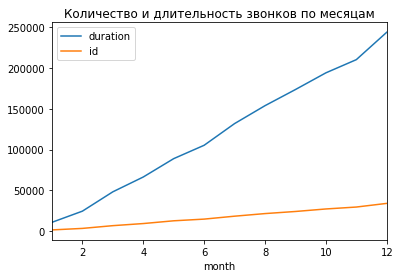

In [ ]:
calls_grouped.plot()
plt.title('Количество и длительность звонков по месяцам')
plt.show()

Количество и длительность звонков линейно увеличиваются от месяца к месяцу, и, соответственно, показывают минимум в январе (1476 совершенных звонков), а максимум в декабре(33987).

Количество отправленных сообщений по месяцам, сначала для каждого пользлвателя, затем общая картина:

In [ ]:
messages_by_month = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index().rename(columns={'id':'messages_by_month_total'})
messages_by_month                       
                        

,user_id,month,messages_by_month_total
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [ ]:
messages_grouped = messages.groupby('month').agg({'id':'count'})
messages_grouped

,id
month,
1,924
2,1924
3,3648
4,5179
5,7298
6,8983
7,11320
8,13088
9,14759


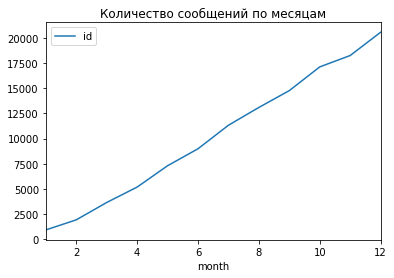

In [ ]:
messages_grouped.plot()
plt.title('Количество сообщений по месяцам')
plt.show()

Количество сообщений также линейно увеличивается от месяца к месяцу, и, соответственно, показывают минимум в январе (924), а максимум в декабре (20555).

Объем израсходованного интернет-трафика по месяцам:

In [ ]:
internet_by_month = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index().rename(columns={'mb_used':'internet_by_month_total'})
internet_by_month                                               

,user_id,month,internet_by_month_total
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0
...,...,...,...
3198,1498,10,20604.0
3199,1499,9,1848.0
3200,1499,10,17809.0
3201,1499,11,17984.0


In [ ]:
internet_grouped = internet.groupby('month').agg({'mb_used':'sum'})
internet_grouped

,mb_used
month,
1,408213.0
2,956348.0
3,1813960.0
4,2436111.0
5,3529893.0
6,4184770.0
7,5035299.0
8,6005126.0
9,6454931.0


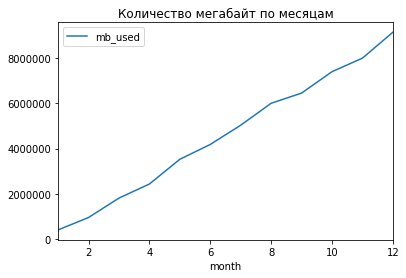

In [ ]:
internet_grouped.plot()
plt.title('Количество мегабайт по месяцам')
plt.show()


Абсолютно такая же картина с интернетом. Минимум 408 ГБ в январе и 9 ТБ в декабре. Видимо, мы наблюдаем становление нового поставщика связи или запуск новых тарифов.

In [ ]:

calls.groupby('month')['user_id'].nunique()

month
1      43
2      82
3     114
4     165
5     205
6     244
7     289
8     337
9     370
10    411
11    444
12    470
Name: user_id, dtype: int64

Для того, чтобы найти **помесячную выручку с каждого пользователя**, склеим в единый ДФ таблицы с необходимыми данными: количеством звонков, сообщений, интернет-трафика за месяц, условия тарификации, данные пользователей.

In [ ]:
df = calls_by_month.merge(messages_by_month, on=['user_id','month'], how='outer')

In [ ]:
df = df.merge(internet_by_month, on=['user_id','month'], how = 'outer')


In [ ]:
df = df.merge(users, on='user_id', how='left')


In [ ]:

df = df.merge(tariffs, on='tariff', how='left')
df

,user_id,month,calls_by_month_duration,calls_by_month_total,messages_by_month_total,internet_by_month_total,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,43.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,47.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,52.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,58.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17232.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3210,1489,10,NaN,NaN,21.0,19588.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3211,1489,11,NaN,NaN,20.0,17516.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3212,1489,12,NaN,NaN,35.0,17341.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3


Проверим новый ДФ на наличие дубликатов и пропусков:

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isna().sum()

user_id                       0
month                         0
calls_by_month_duration      40
calls_by_month_total         40
messages_by_month_total     497
internet_by_month_total      11
age                           0
churn_date                 3027
city                          0
first_name                    0
last_name                     0
reg_date                      0
tariff                        0
messages_included             0
mb_per_month_included         0
minutes_included              0
rub_monthly_fee               0
rub_per_gb                    0
rub_per_message               0
rub_per_minute                0
dtype: int64

Судя по всему, эти пропуски связаны с тем, что мы склеивали таблицы с разным количеством строк, пока оставим их. 

Найдем **помесячную выручку** за связь: вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану. Чтобы найти доход сразу от звонков, сообщений и интерента, напишем функцию.

In [ ]:
def added_expenses (row):
    calls_exp = (row['calls_by_month_duration'] - row['minutes_included']) * row['rub_per_minute']
    messages_exp = (row['messages_by_month_total'] - row['messages_included']) * row['rub_per_message']
    internet_exp = np.ceil((row['internet_by_month_total'] - row['mb_per_month_included']) * row['rub_per_gb'] / 1024)
    total = 0
    for i in [calls_exp, messages_exp, internet_exp]:
        if i > 0:
            total += i
    return total
    

In [ ]:
df['added_expenses'] = df.apply(added_expenses, axis=1)

Прибавим к расходам абонентскую плату:

In [ ]:
df['total_paid'] = df['rub_monthly_fee'] + df['added_expenses']
df

,user_id,month,calls_by_month_duration,calls_by_month_total,messages_by_month_total,internet_by_month_total,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,added_expenses,total_paid
0,1000,5,159.0,22.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
1,1000,6,172.0,43.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
2,1000,7,340.0,47.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
3,1000,8,408.0,52.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
4,1000,9,466.0,58.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17232.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,366.0,916.0
3210,1489,10,NaN,NaN,21.0,19588.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,826.0,1376.0
3211,1489,11,NaN,NaN,20.0,17516.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,422.0,972.0
3212,1489,12,NaN,NaN,35.0,17341.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,387.0,937.0


,mean,median,sum
,total_paid,total_paid,total_paid
tariff,,,
smart,1233.641095,960.0,2749786.0
ultra,2060.598985,1950.0,2029690.0


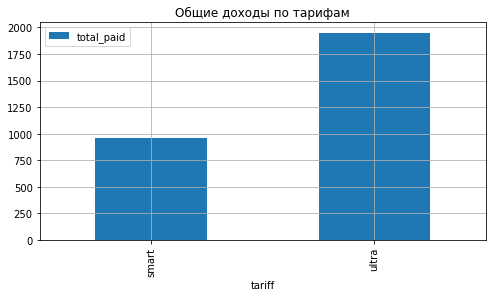

In [ ]:
pt_tariff = df.pivot_table(index = 'tariff', values = 'total_paid', aggfunc = ['mean', 'median', 'sum'])
pt_tariff.plot(y= 'median', kind='bar', grid=True, figsize=(8, 4))
plt.title('Общие доходы по тарифам')
pt_tariff

Общая выручка "Мегалайна" за весь рассматриваемый период от тарифа Смарт (2,7 млн.) в 1,3 раза выше, чем от тарифа Ультра (2 млн.). При этом средний показатель по выручке от Смарт в 2 раза ниже.

,median,sum
,total_paid,total_paid
month,,
1,550.0,41440.0
2,710.5,94013.0
3,1544.5,160292.0
4,1194.0,213076.0
5,1464.5,299433.0
6,1541.5,359271.0
7,1460.0,426720.0
8,1619.0,517437.0


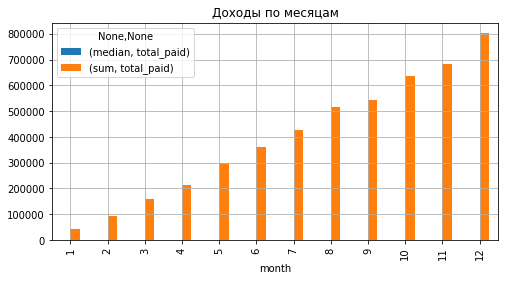

In [ ]:
pt_monthly_paid = df.pivot_table(index = 'month', values = 'total_paid', aggfunc = ['median', 'sum'])
pt_monthly_paid.plot(kind='bar', grid=True, figsize=(8, 4))
plt.title('Доходы по месяцам')
pt_monthly_paid

С каждым месяцем расходы пользователей на связь растут. Так, суммарный доход в конце года превысил доход в начале года аж в 19,3 раз! Среднее значение дохода показывает нам разницу в 3,3 раз. Если средний доход от клиента в месяц составлял 550 рублей, что являтся абонентской платой за тариф Смарт, то в декабре выручка уже стала 1855 рублей.

**Анализ данных**

Опишем поведение клиентов оператора, исходя из выборки. 

In [ ]:
df['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

Тариф Смарт имеет в 2,2 раза больше пользователей, чем Ультра.

Посмотрим на доходы от каждого тарифа.

In [ ]:
ultra = df[df['tariff'] == 'ultra']['total_paid']

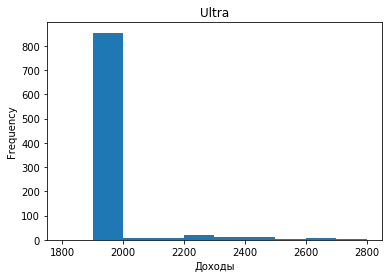

In [ ]:
ultra.plot(kind = 'hist', bins = 10, label = 'ultra', figsize = (6,4), range = (1800,2800))
plt.title('Ultra')
plt.xlabel('Доходы')
plt.show() 

In [ ]:
smart = df[df['tariff'] == 'smart']['total_paid']

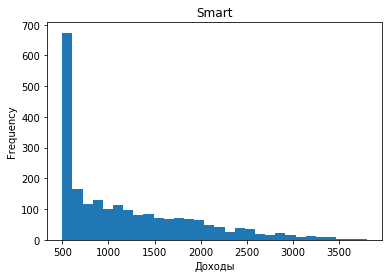

In [ ]:
smart.plot(kind = 'hist', bins = 30, label = 'smart', figsize = (6,4), range = (500,3800))
plt.title('Smart')
plt.xlabel('Доходы')
plt.show()                                                                         


                                                                            

In [ ]:
df.pivot_table(index = 'tariff', values = ['calls_by_month_duration',
                                                        'messages_by_month_total',
                                                        'internet_by_month_total','total_paid'], aggfunc = ["median",
                                                                                     "mean",
                                                                                     'var',
                                                                                     'std'])

median                          \
       calls_by_month_duration internet_by_month_total   
tariff                                                   
smart                    423.0                 16532.0   
ultra                    528.0                 19411.0   

                                                             mean  \
       messages_by_month_total total_paid calls_by_month_duration   
tariff                                                              
smart                     34.0      960.0              419.062978   
ultra                     51.0     1950.0              545.451104   

                                                                     \
       internet_by_month_total messages_by_month_total   total_paid   
tariff                                                                
smart             16236.472621               38.716441  1233.641095   
ultra             19686.767179               61.161006  2060.598985   

                           var                          \
       calls_by_month_duration internet_by_month_total   
tariff                                                   
smart             35844.189551            3.444310e+07   
ultra             94203.418396            9.904344e+07   

                                                                  std  \
       messages_by_month_total     total_paid calls_by_month_duration   
tariff                                                                  
smart               717.594201  620699.733786              189.325618   
ultra              2109.659183  127060.630690              306.925754   

                                                                    
       internet_by_month_total messages_by_month_total  total_paid  
tariff                                                              
smart              5868.824472               26.787949  787.844994  
ultra              9952.057054               45.931026  356.455650

Сравним разницу между медианой и средним.

Смарт: данные скошены вправо для количества отправленных в месяц сообщений и общего счета за связь. Клиенты тарифа Смарт переплачивают, скорее всего, за дополнительные минуты или трафик.

Также мы видим бОльший разброс у Ультра в показателях звонков, сообщений и интернета. Это неудивительно, ведь Ультра предоставляет больше минут, смс и мегабайт. Но противоположную картину мы видим для оплаченных счетов, что говорит о том, что пользователи тарифа Смарт могут платить как значительно меньше, так и значительно больше пользователей тарифа Ультра.

Основная масса клиентов Ультра платит за предоставленный пакет услуг.

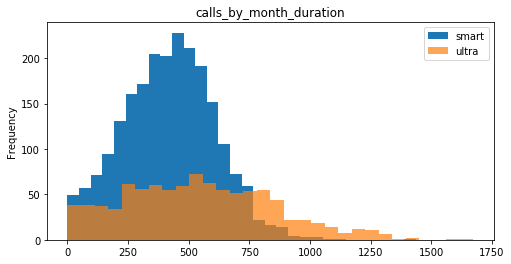

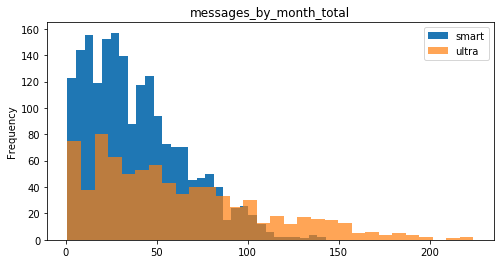

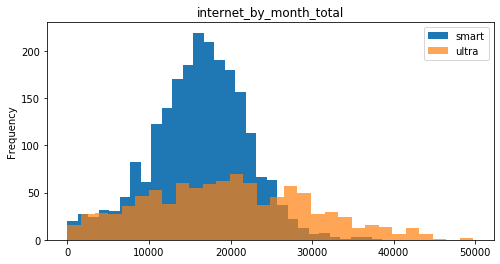

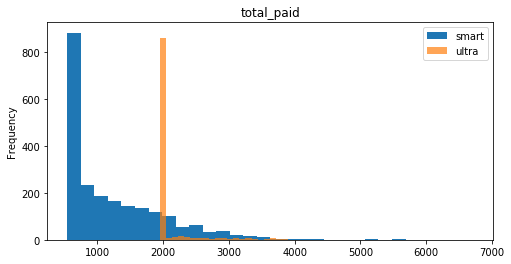

In [ ]:
list_of_columns=['calls_by_month_duration','messages_by_month_total','internet_by_month_total','total_paid']
tariffs = ['ultra','smart']
for column in list_of_columns:
        df.loc[df.loc[:,'tariff'] == 'smart'][column].plot(
                                                                            kind = 'hist',
                                                                            bins = 30,
                                                                            label = 'smart', figsize = (8,4)
                                                                           )
                                                                          
        df.loc[df.loc[:,'tariff'] == "ultra"][column].plot(
                                                                            kind = 'hist',
                                                                            bins = 30,
                                                                            alpha =0.7,
                                                                            label = 'ultra',figsize = (8,4)
                                                                           )
        plt.title(column)
        plt.legend()
        plt.show()

По тарифному плану "Смарт" включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика. В среднем пользователи тарифа «Смарт» говорят по телефону 423 минуты в месяц, что укладывается в тарифный пакет. Однако, на гистограмме видно, что чуть меньше половины превышают этот лимит. Средний показатель по сообщениям составляет 34 смс. Треть пользователей превышают лимит в 50 сообщений. Среднее по потреблению интернет трафика - 16,12 ГБ, основная масса потребления находится в диапазаоне 10-25 ГБ.

По тарифному плану "Ультра" включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика.

В среднем пользователи тарифа «Ультра» говорят по телефону 528 минут в месяц, что укладывается в тарифный пакет. Основная часть клиентов использует 750 минут, и включенные 3000 минут оказываются лишними. Средний показатель по сообщениям составляет 51 смс. Однако, на гистограмме видно, что основная масса отправленных сообщений лежит в пределах 100, и включенные 1000 смс также оказываются лишними. Среднее по потреблению интернет трафика - 18,9 ГБ. Основная масса потребления не превышает включенный в тариф лимит.

Таким образом, мы видим, что при подключении тарифа «Смарт» клиент испытывает недостаток по минутам разговора и гигабайтам интернета, а клиенты, подключившие тариф «Ультра», не используют все минуты и смс, включенные в пакет.

Посмотрим, сколько переплачивают клиенты по каждому тарифу.

count    1665.000000
mean      915.216817
std       786.773010
min         2.000000
25%       297.000000
50%       729.000000
75%      1350.000000
max      6162.000000
Name: added_expenses, dtype: float64

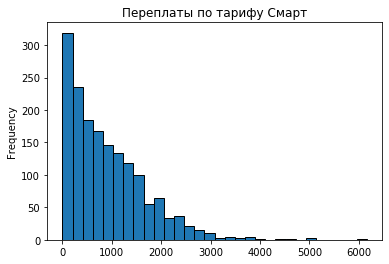

In [ ]:
over_lim_smart = df[(df['tariff'] == 'smart') & (df['added_expenses'] > 0)]['added_expenses']                     
over_lim_smart.plot(kind='hist', ec='black', bins=30)
plt.title('Переплаты по тарифу Смарт')
over_lim_smart.describe()

По тарифу Смарт переплатило 1665 человека. В среднем сумма переплат составляла 730 рублей. Основная масса клиентов переплачивала до 1200 рублей.

count     134.000000
mean      812.985075
std       603.932725
min        42.000000
25%       332.000000
50%       654.000000
75%      1208.000000
max      2794.000000
Name: added_expenses, dtype: float64

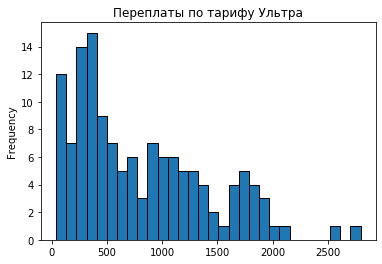

In [ ]:
over_lim_ultra = df[(df['tariff'] == 'ultra') & (df['added_expenses'] > 0)]['added_expenses']                     
over_lim_ultra.plot(kind='hist', ec='black', bins=30)
plt.title('Переплаты по тарифу Ультра')
over_lim_ultra.describe()

По тарифу Ультра переплатило 134 человека. В среднем сумма переплат составляла 650 рублей. Основная масса клиентов переплачивала до 1400 рублей.

Таким образом, по параметрам переплат мы видим, что пакета тарифа Сматрт не хватает больше, чем половине клиентов. Возможным решением может стать тариф с пакетом 700 минут и безлимитный или 25 ГБ интернет стоимостью в пределах 1000-1200 рублей. Тем не менее, из двух имеющихся тарифов наиболее оптимальным для пользователей является Ультра, несмотря на то, что он дороже в 3,5 раза. Очевидно, что клиенты готовы платить за интернет, основная их масса расходует 10-25 ГБ. Но тариф Смарт принес компании больше денег за год.


 
В целом предоставленные нам данные оказались довольно чистыми. Мы привели некоторые значения к целому, к единому временному формату, округлили.
В данных было много нулевых значений по звонкам и интернету.
Нами было принято решение не избавляться от нулей и выбросов. Мы сделали предположения о причине их появления. Нули не влияют на решение поставленных задач, а выбросы влияют на итоговую выручку. Например, клиенты, которые говорят по 1500 минут или используют 50 ГБ интернета, и, как следствие, переплачивают по 6000 рублей ежемесячно, на наш взгляд, должны быть включены в анализ, как важные элементы формирования итоговой выручки компании. К тому же, мы не располагаем информацией о том, являются ли нулевые значения ошибкой.

Столбец churn_date почти полностью состоял из пропусков. Мы знаем, что это закономерно, но в будущем предложили бы “Мегалайну” все-таки заполнять этот столбец в каком-либо datetime формате.

Считая показатели потребленных минут, смс и интернет-трафика за месяц, мы выяснили, что существует линейный рост каждый месяц, и предположили, что мы наблюдаем запуск самого “Мегалайна” или тарифов Смарт и Ультра.

При подсчете помесячной выручки оказалось, что общая выручка "Мегалайна" за весь рассматриваемый период от тарифа Смарт в 1,3 раза выше, чем от тарифа Ультра. При этом средний показатель по выручке от Смарт в 2 раза ниже.
Клиентам тарифа Смарт приходится переплачивать за дополнительные минуты и мегабайты. Очевидно, что предоставленного пакета им не хватает. У клиентов Ультра, наоборот, минут и интернета в избытке. Смс же и вовсе нужны пользователям меньше всего. В будующем стоит ориентироваться на средний показатель выручки. Такой разброс в пользовательском поведении, особенно огромное количество доплат в Смарт и малое количество клиентов в Ультра, говорит о том, что ни один их рассматриваемых тарифов не являются оптимальным.




**3. Проверьте гипотезы**

средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Поясните:

как вы формулировали нулевую и альтернативную гипотезы;

какой критерий использовали для проверки гипотез и почему.

**Гипотеза № 1**

Н0: Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается.

Н1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Мы уже выяснили, что выручка "Мегалайна" от тарифа Смарт (2,7 млн.) в 1,3 раза выше, чем от тарифа Ультра (2 млн.). Несмотря на то, что за Ультра приходится платить в 3,5 раза больше, Смарт в 2,2 раза популярнее и сверх установленного лимита переплачивает в 12 раз больше клиентов.

С помощью методов матстатистики проверим, были ли мы правы. Используем метод ttest_ind для двух независимых выборок с разной дисперсией. Установим уровень значимости в 0,05 - мы отвергнем Н0 с вероятностью 5% и меньше. equal_var = False, потому что дисперсии наших выборок отличаются.




In [ ]:
alpha = 0.05
results = st.ttest_ind(df[df['tariff'] == 'smart']['total_paid'], df[df['tariff'] == 'ultra']['total_paid'], equal_var = False)

print('P-value:', results.pvalue)

if (results.pvalue < alpha):
   print("Отвергаем нулевую гипотезу")
else:
   print("Не получилось отвергнуть нулевую гипотезу")

P-value: 1.620572799195892e-295
Отвергаем нулевую гипотезу


Вероятность случайного совпадения средних наших выборок ничтожно мало, поэтому мы отвергаем гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается.

**Гипотеза № 2**

 Используем метод ttest_ind для двух независимых выборок с разной дисперсией. Установим уровень значимости в 0,05 - мы отвергнем Н0 с вероятностью 5% и меньше.

equal_var = False, потому что дисперсии наших выборок отличаются.

Н0: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов;

Н1: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [ ]:
alpha = 0.05
results = st.ttest_ind(df[df['city'] == 'Москва']['total_paid'], df[df['city'] != 'Москва']['total_paid'], equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
   print("Отвергаем нулевую гипотезу")
else:
   print("Не получилось отвергнуть нулевую гипотезу")

P-value: 0.4553974892423337
Не получилось отвергнуть нулевую гипотезу


C вероятностью в почти 40% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между выручкой от Москвы и остальных регионов.


Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
С вероятностью 60% можно делать вывод о том, что клиенты из Москвы и регионов приносят “Мегалайну” одинаковый доход.


**Общий вывод**

Общая выручка "Мегалайна" за весь рассматриваемый период от тарифа Смарт (2,7 млн.) в 1,3 раза выше, чем от тарифа Ультра (2 млн.). При этом средний показатель по выручке от Смарт в 2 раза ниже, несмотря на то, что Смарт в 2,2 популярнее у клиентов.

Клиенты тарифа Смарт переплачивают  за дополнительные минуты или трафик.
По тарифу Смарт переплатило 1665 человека. В среднем сумма переплат составляла 730 рублей. Основная масса клиентов переплачивала до 1200 рублей. Пакета тарифа Сматрт не хватает больше, чем половине клиентов.

По тарифу Ультра переплатило 134 человека. В среднем сумма переплат составляла 650 рублей. Основная масса клиентов переплачивала до 1400 рублей. У клиентов тарифа Ультра минут, смс и интернета в избытке. Данный тариф не оптимален из-за своей дороговизны и чрезмерности предоставляемых ресурсов. Тем не менее, в среднем он приносит больше выручки “Мегалайну”.

Наиболее оптимальным решением может стать тариф с пакетом 700-750 минут, 50-100 смс и 25 ГБ интернета стоимостью в пределах 1000 рублей. Такой тариф мог бы стать популярным, доступным и удовлетворить все основные потребности клиентов в объеме услуг связи.

Мы не видим смысла вводить отдельный тариф для клиентов в Москве.
